In [1]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, logging
from tqdm import tqdm
logging.set_verbosity_error()
from peft import LoraConfig, PeftConfig, PeftModel
from trl import SFTTrainer
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import numpy as np
import os
import sys
import gc
milestone_2_path = os.path.abspath("../milestone 2")
sys.path.append(milestone_2_path)

import import_preprocess
from importlib import reload
reload(import_preprocess)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int

2025-01-15 21:20:29.292012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 21:20:29.292043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 21:20:29.293063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 21:20:29.298712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 21:20:30.025749: W tensorflow/compiler/tf2

# Some initial testing with different Llama models

In [3]:
# # model_id = "meta-llama/Llama-3.2-3B"
# model_id = "meta-llama/Llama-3.2-3B-Instruct"
# tokenizer = AutoTokenizer.from_pretrained(model_id)
#
# # gptq_config = GPTQConfig(
# #     bits=bits,
# #     tokenizer=tokenizer,
# #     use_exllama=False,
# #     use_cuda_fp16=True,
# #     dataset="c4-new"
# # )
#
# model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     device_map="cuda:0"
# )
#
# model.config.use_cache = False
#
# pipe = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     # torch_dtype=torch.float16,
#     # device="",
# )
# # quantized_model.save_pretrained(f"test-{model_name}-{bits}bit")

In [4]:
# tokenizer.pad_token_id = tokenizer.eos_token_id
# model.config.use_cache = False
#
# messages = [{"role": "user", "content": "Tell me something unexpected about austria"}]
#
# prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
# # outputs = pipe(prompt, max_new_tokens=120, do_sample=True, temperature=0.7)
# outputs = pipe(prompt, max_new_tokens=1000)#, temperature=1.0)
# print(outputs[0]["generated_text"])

# Load data

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset(n_samples=7000)

_, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
_, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
_, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
_, y_balanced, S_balanced, y_balanced_multi = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced, import_preprocess.S_train_balanced, import_preprocess.y_train_multi_balanced

print("Number of training samples:", len(y_train))
print("Number of validation samples:", len(y_val))
print("Number of test samples:", len(y_test))
print("Number of balanced samples:", len(y_balanced))

train_df = pd.DataFrame({"comment": S_train, "label": y_train, "multi_label": y_train_multi})
val_df = pd.DataFrame({"comment": S_val, "label": y_val, "multi_label": y_val_multi})
test_df = pd.DataFrame({"comment": S_test, "label": y_test, "multi_label": y_test_multi})
balanced_df = pd.DataFrame({"comment": S_balanced, "label": y_balanced, "multi_label": y_balanced_multi})

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 14000


In [3]:
def generate_prompt(entry):
    return f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: {entry["comment"]}
label: {entry["label"]}
""".strip()

def generate_test_prompt(entry):
    return f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: {entry["comment"]}
label:
""".strip()

train_df["text"] = train_df.apply(generate_prompt, axis=1)
val_df["text"] = val_df.apply(generate_prompt, axis=1)
balanced_df["text"] = balanced_df.apply(generate_prompt, axis=1)
test_df["text"] = test_df.apply(generate_test_prompt, axis=1)
train_df.label.value_counts()

label
not sexist    10602
sexist         3398
Name: count, dtype: int64

In [4]:
train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)
balanced_data = Dataset.from_pandas(balanced_df)
test_data = Dataset.from_pandas(test_df)

# Evaluate model without fine-tuning

In [5]:
def clear_memory():
    try:
        global model
        global tokenizer
        del model, tokenizer
    except NameError:
        pass
    finally:
        gc.collect()
        torch.cuda.empty_cache()

In [6]:
clear_memory()

model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)

model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
def predict(test_data, model, tokenizer, categories, temperature=0.01):
    y_pred = []
    categories = categories

    for i in tqdm(range(len(test_data))):
        prompt = test_data[i]["text"]

        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=2,
            temperature=temperature
        )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()

        # Determine the predicted category
        for category in categories:
            if category == answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred

In [19]:
def evaluate(y_true, y_pred):
    labels = ["not sexist", "sexist", "none"]
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)  # Map to -1 if not found, but should not occur with correct data

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))), zero_division=0)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [22]:
def predict_with_attention(test_data, model, tokenizer, categories, temperature=0.01):
    y_pred = []
    all_attention_masks = []  # Store attention masks for all examples

    prompt = test_data["text"]

    # Tokenize the prompt and prepare inputs
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding="max_length",  # Adds consistent padding
        truncation=True,
        max_length=2  # Example max length; change based on your use case
    ).to(model.device)
    # Pass inputs through the model
    with torch.no_grad():
        output = model(**inputs, output_attentions=True)

    # Extract the generated text
    generated_ids = torch.argmax(output.logits[:, -1, :], dim=-1)
    answer = tokenizer.decode(generated_ids, skip_special_tokens=True)

    # Store the attention masks
    all_attention_masks.append(inputs["attention_mask"])

    # Determine the predicted category
    for category in categories:
        if category == answer.lower():
            y_pred.append(category)
            break
    else:
        y_pred.append("none")

    return y_pred, all_attention_masks

y_pred = predict_with_attention(test_data[123], model, tokenizer, ["not sexist", "sexist"])
# evaluate(y_test, y_pred)

  4%|▍         | 152/4000 [00:04<01:43, 37.26it/s]


KeyboardInterrupt: 

# Define functions for fine-tuning

In [8]:
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [9]:
def fine_tune(model, tokenizer, train_dataset, eval_dataset, fine_tuned_dir, new_model_dir, epochs):
    modules = find_all_linear_names(model)

    peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0,
        r=64,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=modules,
    )

    training_arguments = TrainingArguments(
        output_dir=fine_tuned_dir,                    # directory to save and repository id
        num_train_epochs=epochs,                  # number of training epochs
        per_device_train_batch_size=1,            # batch size per device during training
        gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
        gradient_checkpointing=True,              # use gradient checkpointing to save memory
        optim="paged_adamw_32bit",
        logging_steps=1,
        learning_rate=2e-4,                       # learning rate, based on QLoRA paper
        weight_decay=0.001,
        fp16=True,
        bf16=False,
        max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
        max_steps=-1,
        warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
        group_by_length=False,
        lr_scheduler_type="cosine",               # use cosine learning rate scheduler
        evaluation_strategy="epoch",             # Evaluate at the end of every epoch
        report_to=["tensorboard"],                # Log metrics to TensorBoard
        save_strategy="epoch",                    # Save model at the end of every epoch
    )

    trainer = SFTTrainer(
        model=model,
        args=training_arguments,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        peft_config=peft_config,
        tokenizer=tokenizer,
    )

    trainer.train()

    trainer.save_model(fine_tuned_dir)
    tokenizer.save_pretrained(fine_tuned_dir)

    model = PeftModel.from_pretrained(model, fine_tuned_dir)
    model = model.merge_and_unload()

    model.save_pretrained(new_model_dir)
    tokenizer.save_pretrained(new_model_dir)

    del trainer

    return model, tokenizer

# Fine-tune model on train set

In [10]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
output_dir_base = "llama-3.2-fine-tuned-train"
new_model_dir_base = "Llama-3.2-3B-Instruct-Sexism-Classification-Train"

epochs = 5
clear_memory()
output_dir = f"{output_dir_base}-{epochs}"
new_model_dir = f"{new_model_dir_base}-{epochs}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

model, tokenizer = fine_tune(model, tokenizer, train_data, val_data, output_dir, new_model_dir, epochs)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_31370/1456593974.py:35: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'loss': 33.9803, 'grad_norm': 5.787120819091797, 'learning_rate': 7.604562737642586e-07, 'epoch': 0.0005714285714285715}
{'loss': 31.6195, 'grad_norm': 5.855278015136719, 'learning_rate': 1.5209125475285172e-06, 'epoch': 0.001142857142857143}
{'loss': 31.1119, 'grad_norm': 5.110542297363281, 'learning_rate': 2.281368821292776e-06, 'epoch': 0.0017142857142857142}
{'loss': 32.8941, 'grad_norm': 5.166194915771484, 'learning_rate': 3.0418250950570345e-06, 'epoch': 0.002285714285714286}
{'loss': 32.297, 'grad_norm': 5.183338642120361, 'learning_rate': 3.8022813688212926e-06, 'epoch': 0.002857142857142857}
{'loss': 31.0755, 'grad_norm': 5.262838840484619, 'learning_rate': 4.562737642585552e-06, 'epoch': 0.0034285714285714284}
{'loss': 30.8768, 'grad_norm': 5.0454864501953125, 'learning_rate': 5.32319391634981e-06, 'epoch': 0.004}
{'loss': 32.3555, 'grad_norm': 5.9223222732543945, 'learning_rate': 6.083650190114069e-06, 'epoch': 0.004571428571428572}
{'loss': 33.7171, 'grad_norm': 5.25415992

KeyboardInterrupt: 

In [15]:
# y_pred = predict(test_data, model, tokenizer, ["not sexist", "sexist"])
# evaluate(y_test, y_pred)

100%|██████████| 4000/4000 [03:11<00:00, 20.86it/s]


Accuracy: 0.882
Accuracy for label not sexist: 0.945
Accuracy for label sexist: 0.688

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.90      0.94      0.92      3030
      sexist       0.80      0.69      0.74       970
        none       0.00      0.00      0.00         0

    accuracy                           0.88      4000
   macro avg       0.57      0.54      0.55      4000
weighted avg       0.88      0.88      0.88      4000


Confusion Matrix:
[[2863  167    0]
 [ 303  667    0]
 [   0    0    0]]


# Fine-tune model on balanced data set

In [12]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
output_dir_base = "llama-3.2-fine-tuned-balanced"
new_model_dir_base = "Llama-3.2-3B-Instruct-Sexism-Classification-Balanced"

epochs = 5
clear_memory()
output_dir = f"{output_dir_base}-{epochs}"
new_model_dir = f"{new_model_dir_base}-{epochs}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

model, tokenizer = fine_tune(model, tokenizer, balanced_data, val_data, output_dir, new_model_dir, epochs)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_10255/3471778963.py:35: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'loss': 30.7494, 'grad_norm': 4.732024669647217, 'learning_rate': 7.604562737642586e-07, 'epoch': 0.0005714285714285715}
{'loss': 32.7973, 'grad_norm': 5.380793571472168, 'learning_rate': 1.5209125475285172e-06, 'epoch': 0.001142857142857143}
{'loss': 31.0358, 'grad_norm': 5.344639301300049, 'learning_rate': 2.281368821292776e-06, 'epoch': 0.0017142857142857142}
{'loss': 34.0938, 'grad_norm': 4.940124988555908, 'learning_rate': 3.0418250950570345e-06, 'epoch': 0.002285714285714286}
{'loss': 30.5159, 'grad_norm': 5.297969341278076, 'learning_rate': 3.8022813688212926e-06, 'epoch': 0.002857142857142857}
{'loss': 31.6628, 'grad_norm': 5.803340911865234, 'learning_rate': 4.562737642585552e-06, 'epoch': 0.0034285714285714284}
{'loss': 30.5325, 'grad_norm': 4.724386215209961, 'learning_rate': 5.32319391634981e-06, 'epoch': 0.004}
{'loss': 31.5955, 'grad_norm': nan, 'learning_rate': 5.32319391634981e-06, 'epoch': 0.004571428571428572}
{'loss': 31.9261, 'grad_norm': 4.934693813323975, 'learni

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: bdddfb40-d879-4d6b-8a99-235942fa9a7c)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 14.6471, 'grad_norm': 2.530244827270508, 'learning_rate': 0.00019961542639154468, 'epoch': 0.2862857142857143}
{'loss': 15.0642, 'grad_norm': 2.3773229122161865, 'learning_rate': 0.00019961217630166952, 'epoch': 0.28685714285714287}
{'loss': 12.7883, 'grad_norm': 2.3634259700775146, 'learning_rate': 0.00019960891256270223, 'epoch': 0.2874285714285714}
{'loss': 16.534, 'grad_norm': 2.409989595413208, 'learning_rate': 0.00019960563517509007, 'epoch': 0.288}
{'loss': 14.3107, 'grad_norm': 2.5920703411102295, 'learning_rate': 0.00019960234413928207, 'epoch': 0.2885714285714286}
{'loss': 16.4539, 'grad_norm': 2.6124942302703857, 'learning_rate': 0.00019959903945572917, 'epoch': 0.28914285714285715}
{'loss': 14.1189, 'grad_norm': 2.1799705028533936, 'learning_rate': 0.00019959572112488423, 'epoch': 0.2897142857142857}
{'loss': 13.0588, 'grad_norm': 2.398404359817505, 'learning_rate': 0.00019959238914720189, 'epoch': 0.29028571428571426}
{'loss': 15.9837, 'grad_norm': 2.5142257213592

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: f8e47fd9-f455-4214-a533-672da9e4e870)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 11.7286, 'grad_norm': 3.4477603435516357, 'learning_rate': 0.00018969852699287864, 'epoch': 0.8577142857142858}
{'loss': 13.5634, 'grad_norm': 3.185150146484375, 'learning_rate': 0.00018968215730594859, 'epoch': 0.8582857142857143}
{'loss': 14.738, 'grad_norm': 3.41713547706604, 'learning_rate': 0.00018966577533056068, 'epoch': 0.8588571428571429}
{'loss': 15.5164, 'grad_norm': 3.483463764190674, 'learning_rate': 0.00018964938106895969, 'epoch': 0.8594285714285714}
{'loss': 12.6553, 'grad_norm': 3.2651901245117188, 'learning_rate': 0.00018963297452339196, 'epoch': 0.86}
{'loss': 12.0035, 'grad_norm': 2.8237009048461914, 'learning_rate': 0.00018961655569610557, 'epoch': 0.8605714285714285}
{'loss': 14.5935, 'grad_norm': 3.415415048599243, 'learning_rate': 0.00018960012458935026, 'epoch': 0.8611428571428571}
{'loss': 12.7316, 'grad_norm': 2.977797031402588, 'learning_rate': 0.00018958368120537743, 'epoch': 0.8617142857142858}
{'loss': 15.0227, 'grad_norm': 3.1054937839508057, 'l

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 80e3c6ac-48fe-4f2f-907a-1444fb086664)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 8.4553, 'grad_norm': 4.765759468078613, 'learning_rate': 0.00016765789140346917, 'epoch': 1.4291428571428573}
{'loss': 11.1234, 'grad_norm': 4.60590934753418, 'learning_rate': 0.00016763062890379126, 'epoch': 1.4297142857142857}
{'loss': 8.6978, 'grad_norm': 3.5645079612731934, 'learning_rate': 0.00016760335713720726, 'epoch': 1.4302857142857142}
{'loss': 8.897, 'grad_norm': 4.697121620178223, 'learning_rate': 0.00016757607610745403, 'epoch': 1.4308571428571428}
{'loss': 8.5828, 'grad_norm': 4.12991189956665, 'learning_rate': 0.00016754878581826964, 'epoch': 1.4314285714285715}
{'loss': 7.3146, 'grad_norm': 4.577980041503906, 'learning_rate': 0.0001675214862733935, 'epoch': 1.432}
{'loss': 6.5289, 'grad_norm': 3.533066749572754, 'learning_rate': 0.0001674941774765662, 'epoch': 1.4325714285714286}
{'loss': 11.4034, 'grad_norm': 5.274235248565674, 'learning_rate': 0.00016746685943152975, 'epoch': 1.4331428571428573}
{'loss': 8.9921, 'grad_norm': 5.194380283355713, 'learning_rate

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: d8fa97a5-675c-4cbc-a3c1-acadcf688749)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 8.2573, 'grad_norm': 3.894968032836914, 'learning_rate': 0.0001365045654153481, 'epoch': 2.0005714285714284}
{'loss': 5.575, 'grad_norm': 4.071121692657471, 'learning_rate': 0.00013647010091272457, 'epoch': 2.0011428571428573}
{'loss': 8.8421, 'grad_norm': 4.336993217468262, 'learning_rate': 0.00013643563141288296, 'epoch': 2.001714285714286}
{'loss': 6.2001, 'grad_norm': 4.388077735900879, 'learning_rate': 0.0001364011569205464, 'epoch': 2.0022857142857142}
{'loss': 5.9033, 'grad_norm': 4.925012111663818, 'learning_rate': 0.00013636667744043864, 'epoch': 2.0028571428571427}
{'loss': 3.8692, 'grad_norm': 4.130459308624268, 'learning_rate': 0.00013633219297728416, 'epoch': 2.0034285714285716}
{'loss': 4.5376, 'grad_norm': 4.834981918334961, 'learning_rate': 0.00013629770353580805, 'epoch': 2.004}
{'loss': 4.7451, 'grad_norm': 5.068552017211914, 'learning_rate': 0.00013626320912073616, 'epoch': 2.0045714285714284}
{'loss': 5.0213, 'grad_norm': 4.199767589569092, 'learning_rate':

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 50cc2e44-c4cc-45da-8cf1-bf41e5134900)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 7.9398, 'grad_norm': 6.51084566116333, 'learning_rate': 0.00010035165628251455, 'epoch': 2.572}
{'loss': 5.7956, 'grad_norm': 5.50083589553833, 'learning_rate': 0.00010031463996106174, 'epoch': 2.5725714285714285}
{'loss': 6.6866, 'grad_norm': 7.0658698081970215, 'learning_rate': 0.0001002776235964962, 'epoch': 2.573142857142857}
{'loss': 3.4755, 'grad_norm': 6.049550533294678, 'learning_rate': 0.00010024060719389002, 'epoch': 2.573714285714286}
{'loss': 6.5583, 'grad_norm': 6.359775543212891, 'learning_rate': 0.00010020359075831529, 'epoch': 2.5742857142857143}
{'loss': 9.1667, 'grad_norm': 6.638404846191406, 'learning_rate': 0.00010016657429484408, 'epoch': 2.5748571428571427}
{'loss': 6.1868, 'grad_norm': 5.336061954498291, 'learning_rate': 0.00010012955780854851, 'epoch': 2.5754285714285716}
{'loss': 5.7631, 'grad_norm': 6.18257999420166, 'learning_rate': 0.00010009254130450059, 'epoch': 2.576}
{'loss': 6.3136, 'grad_norm': 6.539950847625732, 'learning_rate': 0.00010005552

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 8bd99d88-2929-412c-90d0-c48deca88bef)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 3.4822, 'grad_norm': 7.786175727844238, 'learning_rate': 6.415111007946855e-05, 'epoch': 3.1434285714285712}
{'loss': 4.1381, 'grad_norm': 5.915493488311768, 'learning_rate': 6.411655635010907e-05, 'epoch': 3.144}
{'loss': 4.8815, 'grad_norm': 7.534849643707275, 'learning_rate': 6.408200753758247e-05, 'epoch': 3.1445714285714286}
{'loss': 4.9636, 'grad_norm': 7.793608665466309, 'learning_rate': 6.40474636466228e-05, 'epoch': 3.145142857142857}
{'loss': 5.0784, 'grad_norm': 6.332727432250977, 'learning_rate': 6.401292468196325e-05, 'epoch': 3.145714285714286}
{'loss': 5.2741, 'grad_norm': 6.6988205909729, 'learning_rate': 6.397839064833646e-05, 'epoch': 3.1462857142857144}
{'loss': 5.0467, 'grad_norm': 7.258652687072754, 'learning_rate': 6.394386155047443e-05, 'epoch': 3.146857142857143}
{'loss': 3.8425, 'grad_norm': 6.757326126098633, 'learning_rate': 6.39093373931083e-05, 'epoch': 3.1474285714285712}
{'loss': 2.3924, 'grad_norm': 4.468634128570557, 'learning_rate': 6.38748181

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 8fcfb1de-a4a0-4deb-91e4-06b1e2ea2379)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 4.3161, 'grad_norm': 6.411740303039551, 'learning_rate': 3.280682884621432e-05, 'epoch': 3.714857142857143}
{'loss': 4.2907, 'grad_norm': 6.1978840827941895, 'learning_rate': 3.277941852516968e-05, 'epoch': 3.7154285714285713}
{'loss': 2.7616, 'grad_norm': 5.980288505554199, 'learning_rate': 3.275201741484551e-05, 'epoch': 3.716}
{'loss': 4.2601, 'grad_norm': 5.409669876098633, 'learning_rate': 3.272462551899632e-05, 'epoch': 3.7165714285714286}
{'loss': 5.7101, 'grad_norm': 6.415942668914795, 'learning_rate': 3.2697242841375456e-05, 'epoch': 3.717142857142857}
{'loss': 5.5221, 'grad_norm': 8.44946002960205, 'learning_rate': 3.266986938573494e-05, 'epoch': 3.717714285714286}
{'loss': 3.3593, 'grad_norm': 5.182529926300049, 'learning_rate': 3.264250515582551e-05, 'epoch': 3.7182857142857144}
{'loss': 3.5529, 'grad_norm': 6.046370983123779, 'learning_rate': 3.261515015539675e-05, 'epoch': 3.718857142857143}
{'loss': 3.3709, 'grad_norm': 6.776623249053955, 'learning_rate': 3.2587

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: f0832102-9ac4-4e75-99ea-5fe9379dcf59)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 2.4807, 'grad_norm': 4.806296348571777, 'learning_rate': 1.0564861352847112e-05, 'epoch': 4.2862857142857145}
{'loss': 3.0424, 'grad_norm': 6.519264221191406, 'learning_rate': 1.0548307575508587e-05, 'epoch': 4.2868571428571425}
{'loss': 2.1196, 'grad_norm': 4.591911315917969, 'learning_rate': 1.0531766055049019e-05, 'epoch': 4.287428571428571}
{'loss': 3.1364, 'grad_norm': 6.734672546386719, 'learning_rate': 1.0515236793735006e-05, 'epoch': 4.288}
{'loss': 2.7193, 'grad_norm': 6.016191482543945, 'learning_rate': 1.0498719793831379e-05, 'epoch': 4.288571428571428}
{'loss': 2.751, 'grad_norm': 5.2458648681640625, 'learning_rate': 1.0482215057601363e-05, 'epoch': 4.289142857142857}
{'loss': 2.6447, 'grad_norm': 8.199965476989746, 'learning_rate': 1.0465722587306492e-05, 'epoch': 4.289714285714286}
{'loss': 2.6392, 'grad_norm': 6.015456199645996, 'learning_rate': 1.044924238520657e-05, 'epoch': 4.290285714285714}
{'loss': 2.466, 'grad_norm': 5.112088680267334, 'learning_rate': 1.

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 4a281671-d597-4d05-a23f-0b1a3d1dbdce)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 2.8417, 'grad_norm': 5.3091721534729, 'learning_rate': 4.4168110431003217e-07, 'epoch': 4.857714285714286}
{'loss': 3.2311, 'grad_norm': 7.17846155166626, 'learning_rate': 4.382126836728895e-07, 'epoch': 4.8582857142857145}
{'loss': 2.1131, 'grad_norm': 4.535544395446777, 'learning_rate': 4.347579052234374e-07, 'epoch': 4.8588571428571425}
{'loss': 3.1485, 'grad_norm': 6.164166450500488, 'learning_rate': 4.313167694350639e-07, 'epoch': 4.859428571428571}
{'loss': 3.5913, 'grad_norm': 6.360175132751465, 'learning_rate': 4.278892767792808e-07, 'epoch': 4.86}
{'loss': 2.717, 'grad_norm': 4.614716053009033, 'learning_rate': 4.244754277257346e-07, 'epoch': 4.860571428571428}
{'loss': 4.6137, 'grad_norm': 6.816653728485107, 'learning_rate': 4.2107522274219546e-07, 'epoch': 4.861142857142857}
{'loss': 3.1702, 'grad_norm': 7.131324291229248, 'learning_rate': 4.176886622945575e-07, 'epoch': 4.861714285714286}
{'loss': 1.6196, 'grad_norm': 2.9794421195983887, 'learning_rate': 4.14315746

# Trying to explain predictions

In [81]:
def get_next_token_probabilities(prompt, model, tokenizer):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")  # Models are on CUDA

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    next_token_logits = logits[:, -1, :]

    probabilities = torch.softmax(next_token_logits, dim=-1)

    top_k = 5
    top_k_probs, top_k_token_ids = torch.topk(probabilities, k=top_k, dim=-1)

    top_k_tokens = [tokenizer.decode(token_id) for token_id in top_k_token_ids[0]]

    print(f"Next top-{top_k} Tokens and Probabilities:")
    for token, prob in zip(top_k_tokens, top_k_probs[0]):
        if token.strip():
            print(f"Token: '{token}', Probability: {prob.item()*100:.2f}%")
        else:
            print(f"Token: '{repr(token)}', Probability: {prob.item()*100:.2f}%")

def generate_answer(prompt, model, tokenizer, max_new_tokens=2, temperature=0.01):
    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    result = pipe(prompt)
    return result[0]['generated_text']

prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:
""".strip()

print(f"Prompt:\n{prompt}\n")
get_next_token_probabilities(prompt, model, tokenizer)
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")

Prompt:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:

Next top-5 Tokens and Probabilities:
Token: ' not', Probability: 39.28%
Token: ' sexist', Probability: 21.24%
Token: ' __________________', Probability: 6.41%
Token: '' \n'', Probability: 5.26%
Token: ' "', Probability: 2.73%

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label: not sexist


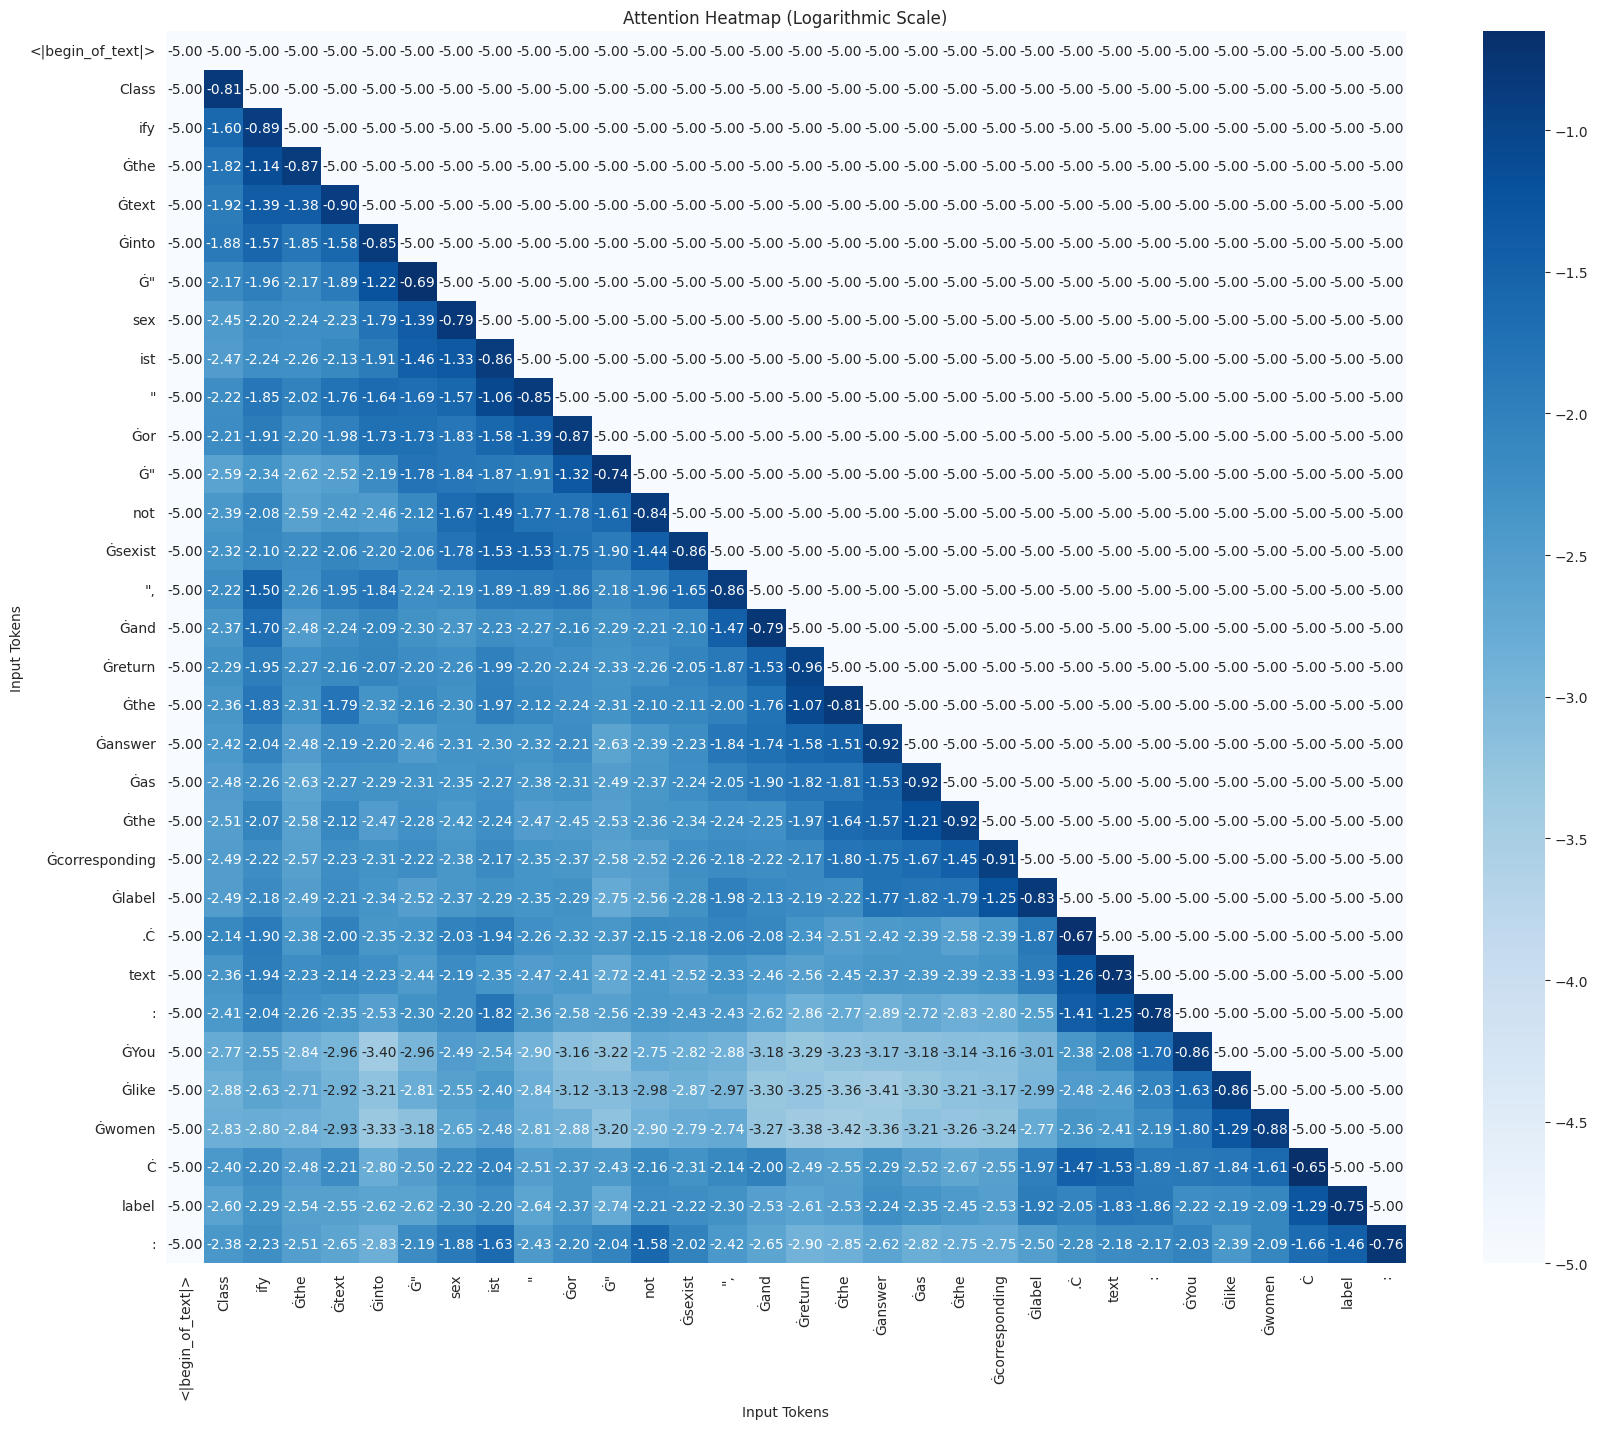

Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: You like women
label: sexist
 

Next top-5 Tokens and Probabilities:
Token: ' sexist', Probability: 81.73%
Token: ' not', Probability: 12.13%
Token: ' "', Probability: 0.85%
Token: '' \n'', Probability: 0.78%
Token: ' sex', Probability: 0.55%


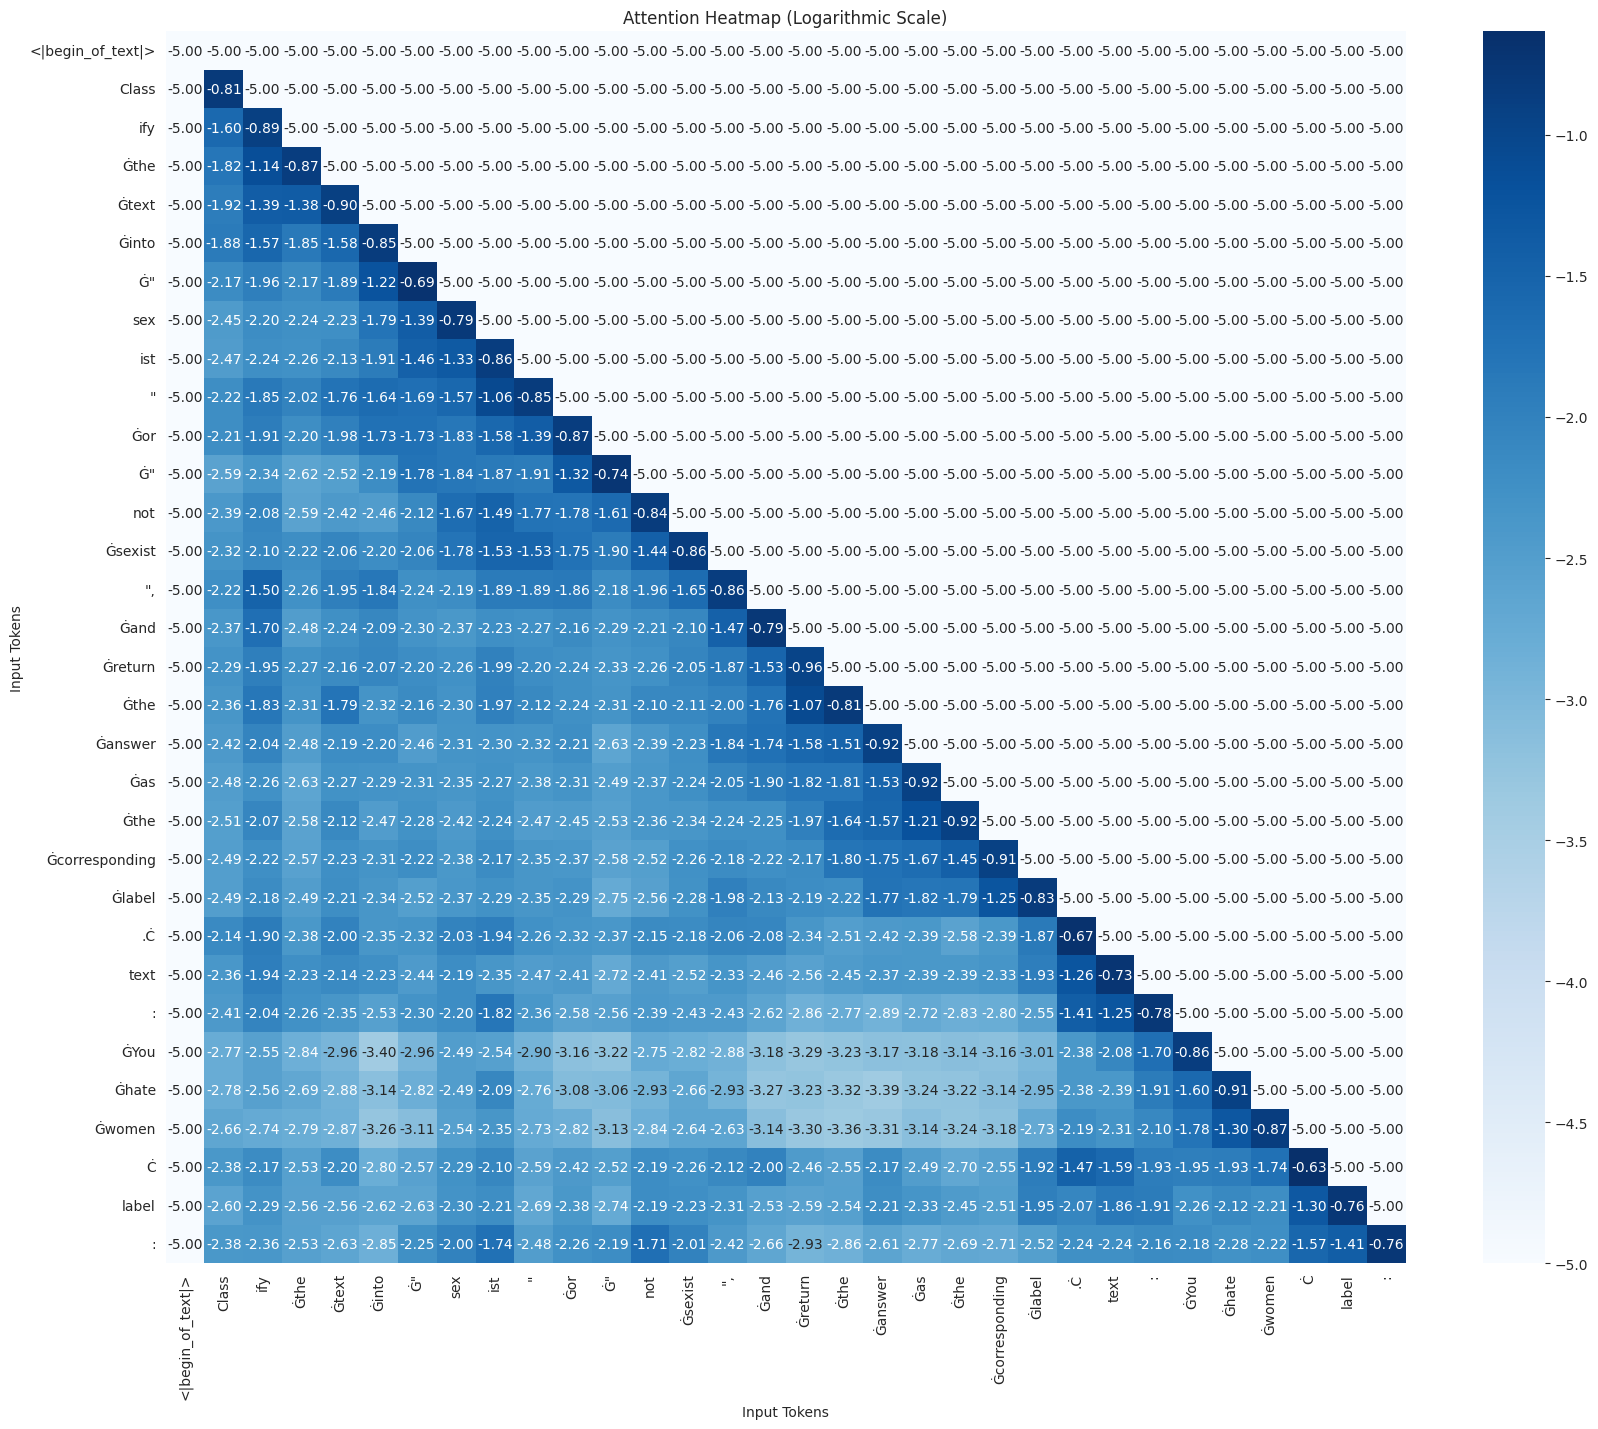

Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: You hate women
label: sexist

 

Next top-5 Tokens and Probabilities:
Token: ' sexist', Probability: 98.09%
Token: ' sex', Probability: 0.35%
Token: '' \n'', Probability: 0.18%
Token: ' "', Probability: 0.17%
Token: ' not', Probability: 0.14%


In [104]:
def visualize_attention_no_padding(prompt, model, tokenizer):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=256,
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions[-1]
    attentions = attentions.squeeze(0)
    avg_attention = attentions.mean(dim=0).cpu().numpy()

    attention_mask = inputs["attention_mask"].cpu().numpy()[0]
    valid_indices = np.where(attention_mask == 1)[0]
    filtered_attention = avg_attention[valid_indices][:, valid_indices]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][valid_indices])

    return filtered_attention, tokens


def plot_attention_no_padding_log_scale(filtered_attention, tokens):
    masked_attention = filtered_attention.copy()
    masked_attention[:, 0] = 0
    masked_attention[0, :] = 0

    log_scaled_attention = np.log10(masked_attention + 1e-5)

    plt.figure(figsize=(20, 16))
    sns.heatmap(log_scaled_attention, xticklabels=tokens, yticklabels=tokens, cmap="Blues", fmt=".2f", annot=True)
    plt.xlabel("Input Tokens")
    plt.ylabel("Input Tokens")
    plt.title("Attention Heatmap (Logarithmic Scale)")
    plt.xticks(rotation=90)
    plt.show()


prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: You like women
label:
""".strip()

filtered_attention, tokens = visualize_attention_no_padding(prompt, model, tokenizer)
plot_attention_no_padding_log_scale(filtered_attention, tokens)
print(generate_answer(prompt, model, tokenizer), "\n")
get_next_token_probabilities(prompt, model, tokenizer)

prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: You hate women
label:
""".strip()

filtered_attention, tokens = visualize_attention_no_padding(prompt, model, tokenizer)
plot_attention_no_padding_log_scale(filtered_attention, tokens)
print(generate_answer(prompt, model, tokenizer), "\n")
get_next_token_probabilities(prompt, model, tokenizer)

In [101]:
prompt = f"""
Classify the text into "sexist" or "not sexist", return the answer as the corresponding label and give an explanation.
text: You are a good waste of air
label:
""".strip()

print(generate_answer(prompt, model, tokenizer, 100))

Classify the text into "sexist" or "not sexist", return the answer as the corresponding label and give an explanation.
text: You are a good waste of air
label: sexist
explanation: The text is sexist because it uses a derogatory term to describe someone, implying that they are not valuable or worthy of respect. The term "good waste of air" is a pejorative expression that is often used to belittle or demean individuals, particularly women. This kind of language contributes to a culture of sexism and objectification, where people are reduced to their physical appearance or perceived usefulness rather than being treated with dignity and respect. 

Note: The text is a


In [82]:
prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:
""".strip()

print(f"Prompt:\n{prompt}\n")
get_next_token_probabilities(prompt, model, tokenizer)
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")

Prompt:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:

Next top-5 Tokens and Probabilities:
Token: ' not', Probability: 39.28%
Token: ' sexist', Probability: 21.24%
Token: ' __________________', Probability: 6.41%
Token: '' \n'', Probability: 5.26%
Token: ' "', Probability: 2.73%

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label: not sexist
